In [ ]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

In [ ]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
train_data, test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

In [ ]:
train_data.features

{'text': Value('string'), 'label': ClassLabel(names=['neg', 'pos'])}

In [ ]:
train_data[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [ ]:
tokenizer = lambda x: x.lower().split()

In [ ]:
tokenizer("Hello world! How are you doing today? I'm doing fantastic!")

['hello',
 'world!',
 'how',
 'are',
 'you',
 'doing',
 'today?',
 "i'm",
 'doing',
 'fantastic!']

In [ ]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    return {"tokens": tokens}

In [ ]:
max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
train_data

Dataset({
    features: ['text', 'label', 'tokens'],
    num_rows: 25000
})

In [ ]:
train_data.features

{'text': Value('string'),
 'label': ClassLabel(names=['neg', 'pos']),
 'tokens': List(Value('string'))}

In [ ]:
train_data[0]["tokens"][:25]

['i',
 'rented',
 'i',
 'am',
 'curious-yellow',
 'from',
 'my',
 'video',
 'store',
 'because',
 'of',
 'all',
 'the',
 'controversy',
 'that',
 'surrounded',
 'it',
 'when',
 'it',
 'was',
 'first',
 'released',
 'in',
 '1967.',
 'i']

In [ ]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [ ]:
len(train_data), len(valid_data), len(test_data)

(18750, 6250, 25000)

In [ ]:
from collections import Counter

counter = Counter(tok for tokens in train_data["tokens"] for tok in tokens)

min_freq = 5
special_tokens = ["<unk>", "<pad>"]

vocab = {tok: i for i, tok in enumerate(special_tokens)} # 0 <unk>, 1 <pad> i = 0,1 . tok = <unk> , <pad>
for word, freq in counter.items():
    if freq >= min_freq:
        vocab[word] = len(vocab)

In [ ]:
len(vocab)

31534

In [ ]:
itos = [tok for tok, _ in sorted(vocab.items(), key= lambda x: x[1])]
print(itos[0:10])

['<unk>', '<pad>', 'look,', 'this', 'is', 'quite', 'possibly', 'one', 'of', 'the']


In [ ]:
vocab["this"]

3

In [ ]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

In [ ]:
"some_token" in vocab

False

In [ ]:
from collections import defaultdict
vocab = defaultdict(lambda: unk_index, vocab)

In [ ]:
vocab["some_token"]

0

In [ ]:
def lookup_indices(tokens, vocab):
    return [vocab.get(tok, unk_index) for tok in tokens]

print(lookup_indices(["hello", "world", "some_token", "<pad>"], vocab))

[25814, 1153, 0, 1]


In [ ]:
def numericalize_example(example, vocab):
    ids = lookup_indices(example["tokens"], vocab)
    return {"ids": ids}

In [ ]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map:   0%|          | 0/18750 [00:00<?, ? examples/s]

Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
train_data[0]["tokens"][:10]

['look,',
 'this',
 'is',
 'quite',
 'possibly',
 'one',
 'of',
 'the',
 'best',
 'movies']

In [ ]:
lookup_indices(train_data[0]["tokens"][:10],vocab)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [ ]:
lookup_indices(['look'], vocab)

[10716, 5047, 5047, 28844]

In [ ]:
import pandas as pd

df = train_data.to_pandas()
print(df.head())   # first 5 rows

                                                text  label  \
0  Look, this is quite possibly one of the best m...      1   
1  What starts out as a gentle country yarn, inof...      0   
2  I got the DVD very cheap and I'm a total Drewb...      0   
3  Debut? Wow--Cross-Eyed is easily one of the mo...      1   
4  I've seen (far too) many flicks from this comp...      0   

                                              tokens  \
0  [look,, this, is, quite, possibly, one, of, th...   
1  [what, starts, out, as, a, gentle, country, ya...   
2  [i, got, the, dvd, very, cheap, and, i'm, a, t...   
3  [debut?, wow--cross-eyed, is, easily, one, of,...   
4  [i've, seen, (far, too), many, flicks, from, t...   

                                                 ids  
0  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...  
1  [77, 78, 41, 56, 28, 79, 80, 81, 82, 37, 83, 8...  
2  [22, 222, 9, 223, 224, 225, 37, 226, 28, 227, ...  
3  [0, 0, 4, 297, 7, 8, 9, 275, 84, 298, 299, 24,...  
4  [300, 

In [ ]:
train_data[0]["ids"][:10]

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [ ]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [ ]:
train_data[0]["label"]

tensor(1)

In [ ]:
train_data[0]["ids"][:10]

tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [ ]:
train_data[0].keys()

dict_keys(['label', 'ids'])

In [ ]:
ids = train_data[0]["ids"][:10]  # already a list
tokens = [itos[i] for i in ids]
print(tokens)


['look,', 'this', 'is', 'quite', 'possibly', 'one', 'of', 'the', 'best', 'movies']


In [ ]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch
    return collate_fn


In [ ]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [ ]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

## Building the Model


In [ ]:
class NBoW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.embedding(ids)
        # embedded = [batch size, seq len, embedding dim]
        pooled = embedded.mean(dim=1)
        # pooled = [batch size, embedding dim]
        prediction = self.fc(pooled)
        # prediction = [batch size, output dim]
        return prediction

In [ ]:
vocab_size = len(itos)  # Use the actual vocabulary size
embedding_dim = 300
output_dim = 2  # Binary classification

model = NBoW(vocab_size, embedding_dim, output_dim, pad_index)

In [ ]:
print(f"Model vocabulary size: {vocab_size}")
print(f"The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

Model vocabulary size: 31534
The model has 9,460,802 trainable parameters


In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 16.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
opencv-python-h

In [ ]:
# # Install: pip install transformers
# from transformers import AutoModel, AutoTokenizer

# # Get pre-trained embeddings
# model_name = "bert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name)


try:
    import gensim.downloader as api
    print("Loading pre-trained word vectors...")
    vectors = api.load("word2vec-google-news-300")

    # Create pretrained embedding matrix
    pretrained_embedding = np.zeros((vocab_size, embedding_dim))
    found_words = 0

    for idx in range(vocab_size):
        word = itos[idx]
        if word in vectors:
            pretrained_embedding[idx] = vectors[word]
            found_words += 1
        else:
            # Random initialization for unknown words
            pretrained_embedding[idx] = np.random.normal(scale=0.1, size=(embedding_dim,))

    # Load pretrained embeddings into model
    pretrained_embedding_tensor = torch.tensor(pretrained_embedding, dtype=torch.float)
    model.embedding.weight.data.copy_(pretrained_embedding_tensor)

    print(f"Found pretrained vectors for {found_words}/{vocab_size} words")

except ImportError:
    print("Gensim not available, using random embeddings")
except Exception as e:
    print(f"Could not load pretrained embeddings: {e}")
    print("Using random embeddings")

Loading pre-trained word vectors...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Found pretrained vectors for 16473/31534 words


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
print(device)

cuda


In [ ]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in tqdm.tqdm(data_loader, desc="Training"):
        ids = batch['ids'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        predictions = model(ids)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        predicted_classes = predictions.argmax(dim=1)
        correct = (predicted_classes == labels).sum().item()

        total_loss += loss.item()
        total_correct += correct
        total_samples += labels.size(0)

    return total_loss / len(data_loader), total_correct / total_samples

In [ ]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="Evaluating"):
            ids = batch['ids'].to(device)
            labels = batch['label'].to(device)

            predictions = model(ids)
            loss = criterion(predictions, labels)

            predicted_classes = predictions.argmax(dim=1)
            correct = (predicted_classes == labels).sum().item()

            total_loss += loss.item()
            total_correct += correct
            total_samples += labels.size(0)

    return total_loss / len(data_loader), total_correct / total_samples

In [ ]:
n_epochs = 10
best_valid_loss = float("inf")
metrics = collections.defaultdict(list)

print("Starting training...")

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    train_loss, train_acc = train(train_data_loader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)

    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow.pt")
        print("Saved best model!")

    print(f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}")
    print(f"Valid Loss: {valid_loss:.3f}, Valid Acc: {valid_acc:.3f}")

print("\nTraining completed!")

Starting training...

Epoch 1/10


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 35.04it/s]


Saved best model!
Train Loss: 0.686, Train Acc: 0.576
Valid Loss: 0.676, Valid Acc: 0.715

Epoch 2/10


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 35.54it/s]


Saved best model!
Train Loss: 0.655, Train Acc: 0.748
Valid Loss: 0.633, Valid Acc: 0.752

Epoch 3/10


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 54.47it/s]


Saved best model!
Train Loss: 0.592, Train Acc: 0.780
Valid Loss: 0.565, Valid Acc: 0.784

Epoch 4/10


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 53.41it/s]


Saved best model!
Train Loss: 0.513, Train Acc: 0.817
Valid Loss: 0.497, Valid Acc: 0.815

Epoch 5/10


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 25.76it/s]


Saved best model!
Train Loss: 0.439, Train Acc: 0.850
Valid Loss: 0.442, Valid Acc: 0.838

Epoch 6/10


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 53.50it/s]


Saved best model!
Train Loss: 0.380, Train Acc: 0.876
Valid Loss: 0.403, Valid Acc: 0.849

Epoch 7/10


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 53.99it/s]


Saved best model!
Train Loss: 0.334, Train Acc: 0.893
Valid Loss: 0.376, Valid Acc: 0.860

Epoch 8/10


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 49.63it/s]


Saved best model!
Train Loss: 0.298, Train Acc: 0.906
Valid Loss: 0.354, Valid Acc: 0.865

Epoch 9/10


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 53.57it/s]


Saved best model!
Train Loss: 0.268, Train Acc: 0.917
Valid Loss: 0.340, Valid Acc: 0.869

Epoch 10/10


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 31.49it/s]


Saved best model!
Train Loss: 0.243, Train Acc: 0.926
Valid Loss: 0.327, Valid Acc: 0.872

Training completed!


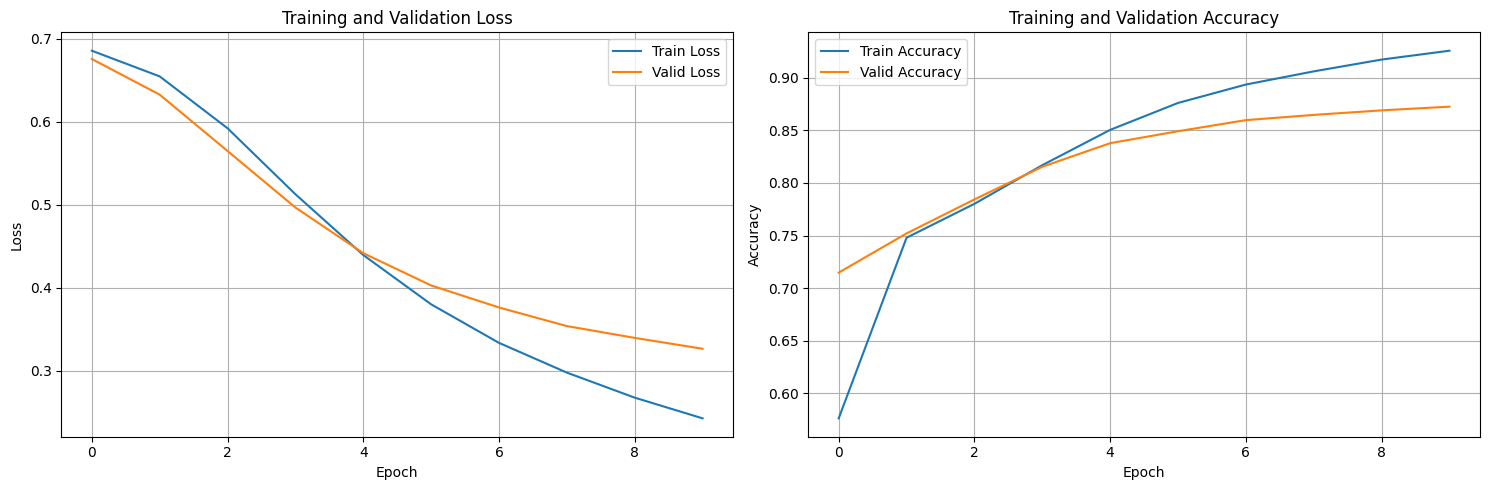

In [ ]:
if len(metrics["train_losses"]) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(metrics["train_losses"], label="Train Loss")
    ax1.plot(metrics["valid_losses"], label="Valid Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_title("Training and Validation Loss")
    ax1.legend()
    ax1.grid()

    # Accuracy plot
    ax2.plot(metrics["train_accs"], label="Train Accuracy")
    ax2.plot(metrics["valid_accs"], label="Valid Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Training and Validation Accuracy")
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.show()
else:
    print("No metrics to plot - training may have failed")

In [ ]:
print("\nEvaluating on test set...")
model.load_state_dict(torch.load("nbow.pt", map_location=device))
test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}")


Evaluating on test set...


Evaluating: 100%|██████████| 49/49 [00:01<00:00, 39.72it/s]

Test Loss: 0.351, Test Accuracy: 0.859


In [ ]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    model.eval()
    tokens = tokenizer(text)
    ids = lookup_indices(tokens, vocab)
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)

    with torch.no_grad():
        prediction = model(tensor).squeeze(dim=0)
        probability = torch.softmax(prediction, dim=-1)
        predicted_class = prediction.argmax(dim=-1).item()
        predicted_probability = probability[predicted_class].item()

    sentiment = "Positive" if predicted_class == 1 else "Negative"
    return sentiment, predicted_probability

# Test predictions
test_texts = [
    "This film is terrible!",
    "This film is great!",
    "This movie is absolutely wonderful and entertaining!",
    "I hate this boring movie."
]

In [ ]:
print("\nTesting predictions:")
for text in test_texts:
    sentiment, prob = predict_sentiment(text, model, tokenizer, vocab, device)
    print(f"Text: '{text}'")
    print(f"Predicted: {sentiment} (confidence: {prob:.3f})")
    print()


Testing predictions:
Text: 'This film is terrible!'
Predicted: Negative (confidence: 0.999)

Text: 'This film is great!'
Predicted: Positive (confidence: 1.000)

Text: 'This movie is absolutely wonderful and entertaining!'
Predicted: Positive (confidence: 0.999)

Text: 'I hate this boring movie.'
Predicted: Negative (confidence: 1.000)



In [ ]:
new_text = "I absolutely didn't love this movie!"
sentiment, confidence = predict_sentiment(new_text, model, tokenizer, vocab, device)

print(f"Text: '{new_text}'")
print(f"Predicted: {sentiment}")
print(f"Confidence: {confidence:.3f}")

Text: 'I absolutely didn't love this movie!'
Predicted: Positive
Confidence: 0.994
